# Car breakdown prediction

We have a fleet of automatic cars of same make & model. Since the drivers don't own the cars, they driver it abusively, which causes more wear and tear. All cars are equipped with sensors to provide the sate of the car on a daily basis (1 reading / day).


1. **Driving Mode sensors:**
The car has 3 different driving modes(Auto, City, Sports), which can be selected only once by the driver on a daily basis. The sensors though are not discrete and is captured as 3 different real numbers, captured as **ecoMode, cityMode, sportsMode**

2. **Engine Sensors**: 
Every is equipped with 21 different kind of sensors. (E.g. engine-rpm, engine-oil level, ac temperature, battery voltage, ...), captured as **s1, s2, s3, ..., s21**

## Dataset

[Car breakdown dataset](car_breakdown_data.ipynb)

# What to predict ?

Given a timeseries data for every **vehicleId** and the day of failure. Can we predict that the break down is going to happen withing 30 days.

## Expectations from the project

* Implementation with a decent accuracy, e.g. 70%
* Checkin the code to github, and email the link
* README.md should capture your approach of implementation
* Document various other techniques which can be used to address the problem, given only the data which is provided in this project.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import itertools
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
%matplotlib inline

In [4]:
train_data = pd.read_csv('data/car_breakdown_train.tsv', sep='\t', header=0)

In [5]:
test_data = pd.read_csv('data/car_breakdown_test.tsv', sep='\t', header=0)

In [6]:
test_truth_data = pd.read_csv('data/car_breakdown_test_truth.tsv', sep='\t', header=0)

In [7]:
train_data['days_to_failure']=train_data.groupby(['vehicleId'])['days'].transform(max)-train_data['days']

In [8]:
train_data['target'] = np.where(train_data['days_to_failure'] <= 30, 1, 0 )

In [9]:
test_truth_data = test_truth_data.set_index(test_truth_data.index + 1)
test_truth_data['maximum_day'] = test_data.groupby('vehicleId')['days'].max() + test_truth_data['RUL']
test_data['days_to_failure'] = [test_truth_data['maximum_day'][i] for i in test_data.vehicleId] - test_data['days']

In [10]:
test_data['target'] = np.where(test_data['days_to_failure'] <= 30, 1, 0 )

In [11]:
#Min-max scaler
def scale(df):
    return (df - df.min())/(df.max()-df.min())

In [12]:
for col in train_data.columns:
    if col[0] == 's':
        train_data[col] = scale(train_data[col])
        
train_data = train_data.dropna(axis=1)

In [13]:
for col in test_data.columns:
    if col[0] == 's':
        test_data[col] = scale(test_data[col])
test_data = test_data.dropna(axis=1)

In [14]:
X_train = train_data[train_data.columns[2:-2]]
Y_train = train_data[train_data.columns[-1]]
X_test = test_data[test_data.columns[2:-2]]
Y_test = test_data[test_data.columns[-1]]

## Solution 1 - Using Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
    
lr = LogisticRegression() # ovr = one (class) versus rest (of classes)
lr.fit(X_train, Y_train)

score = lr.score(X_test, Y_test)
print("Model accurace score on testing data is (in percentage) ", score)

Model accurace score on testing data is (in percentage)  0.8836285888821014


## Solution 2 - Using Support Vector Machine

In [16]:
from sklearn import svm
from sklearn.svm import SVR
svm = svm.SVR()

from sklearn import model_selection
cv = model_selection.KFold(5)

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', svm) ])

# model parameters
param_C = [1]
param_epsilon = [.05, .1, .15]

#select the best model using GridSearch

from sklearn.model_selection import GridSearchCV
svm_model = GridSearchCV(estimator=pipeline,
                             cv=cv, 
                             param_grid =dict(model__C = param_C, model__epsilon = param_epsilon),
                             scoring = 'neg_mean_squared_error',
                             verbose = 1,
                             n_jobs = -1)

svm_model.fit(X_train, Y_train)

print("Best model estimators: ", svm_model.best_estimator_)

# metrics on holdout

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = svm_model.predict(X_test)
print("SVM Mean Squared Error: ", mean_squared_error(Y_test, y_pred))
print("SVM Mean Absolute Error: ", mean_absolute_error(Y_test, y_pred))
print("SVM r-squared: ", r2_score(Y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   46.4s finished


Best model estimators:  Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])
SVM Mean Squared Error:  0.0833437429736549
SVM Mean Absolute Error:  0.15756094092945133
SVM r-squared:  -2.373070779107931


## Solution 3 - Using Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

from sklearn import model_selection
cv = model_selection.KFold(5)

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()), ('model', gbr) ])

# model parameters
param_alpha = [.5, .75, .9]
param_nestimators= [500]
param_learningrate = [0.005, .01]
param_maxdepth = [4, 5, 6]

# select the best model with GridSearch
from sklearn.model_selection import GridSearchCV
gbr_model = GridSearchCV(estimator=pipeline,
                            cv=cv,
                            param_grid =dict(model__max_depth = param_maxdepth, model__n_estimators = param_nestimators,
                                              model__learning_rate = param_learningrate, model__alpha = param_alpha),
                            scoring = 'neg_mean_squared_error',
                            verbose = 1,
                            n_jobs = -1
                           )
gbr_model.fit(X_train, Y_train)
# est model estimators
print(gbr_model.best_estimator_)

# evaluate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = gbr_model.predict(X_test)

print("Gradient Boosting Mean Squared Error: ", mean_squared_error(Y_test, y_pred))
print("Gradient Boosting Mean Absolute Error: ", mean_absolute_error(Y_test, y_pred))
print("Gradient Boosting r-squared: ", r2_score(Y_test, y_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/iadi7ya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 12.6min finished


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', GradientBoostingRegressor(alpha=0.5, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0....s=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])
Gradient Boosting Mean Squared Error:  0.07172772034399538
Gradient Boosting Mean Absolute Error:  0.14646514921524403
Gradient Boosting r-squared:  -1.90294950660945


## Solution 3 - Using Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

from sklearn import model_selection
cv = model_selection.KFold(5)

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()), ('model', rf) ])

# model parameters
param_minsamples_leaf = [2, 25, 50]
param_maxdepth = [8, 9, 10, 12]

# Best model using GridSearch
from sklearn.model_selection import GridSearchCV
rf_model = GridSearchCV(estimator=pipeline,
                            cv=cv,
                            param_grid =dict(model__min_samples_leaf = param_minsamples_leaf, model__max_depth = param_maxdepth),
                            scoring = 'roc_auc',
                            verbose = 1,
                            n_jobs = -1,
                           )
rf_model.fit(X_train, Y_train)

# Best model estimators
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)
print(rf_model.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.2s finished


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


Confusion Matrix:
[[11945   819]
 [   15   317]]
Random Forest Accuracy: 93.6%
Random Forest Precision: 27.9%
Random Forest Recall: 95.5%
Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.94      0.97     12764
          1       0.28      0.95      0.43       332

avg / total       0.98      0.94      0.95     13096



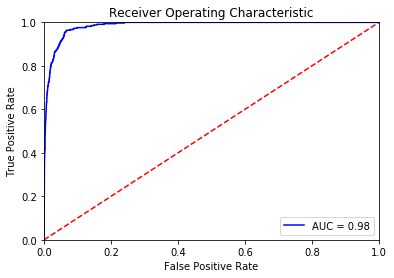

In [19]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))
from sklearn.metrics import classification_report
print("Random Forest Accuracy: "+"{:.1%}".format(accuracy_score(Y_test, y_pred)));
print("Random Forest Precision: "+"{:.1%}".format(precision_score(Y_test, y_pred)));
print("Random Forest Recall: "+"{:.1%}".format(recall_score(Y_test, y_pred)));
print("Classification Report:")
print(classification_report(Y_test, y_pred))
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()